In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.5 MB/s eta 0:00:00


In [4]:
import os

# Path where training data is stored
train_data_path = "/content/drive/MyDrive/Dataset/splitset/"

# Get participant IDs from existing training files
train_participants = [
    file.split("_")[0] for file in os.listdir(train_data_path) if file.endswith("_train.mat")
]
train_participants = sorted(set(map(int, train_participants)))  # Ensure unique and sorted IDs

print("Loaded train participants:", train_participants)

Loaded train participants: [1, 2, 3, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 29, 30, 31, 32, 33, 35, 36, 37, 39, 42, 43, 45, 46, 47, 48]


In [5]:
import numpy as np
import scipy.io
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

sampling_rate = 256

# Define frequency bands
alpha_band = (8, 13)
theta_band = (4, 8)
low_beta_band = (13, 20)
delta_band = (0.5, 4)

# Selected channels (convert to 0-indexed)
selected_channels = [3, 5, 8, 14, 17, 19, 24, 25, 36, 39, 40, 45, 47, 52, 53]
selected_channels = [ch - 1 for ch in selected_channels]

# Power function using CWT
def compute_power_cwt(signal, scales, wavelet):
    coeffs, _ = pywt.cwt(signal, scales, wavelet, sampling_period=1.0/sampling_rate)
    return np.abs(coeffs) ** 2

#Initialize list for relative power features
all_relative_features = []

for participant in train_participants:
    file_path = f'/content/drive/MyDrive/Dataset/splitset/{int(participant)}_train.mat'
    data = scipy.io.loadmat(file_path)
    participant_data = data['train_data']

    trial_duration = 1.5
    segment_duration = 20
    trials_per_segment = int(segment_duration / trial_duration)
    window_duration = 5
    window_length = window_duration * sampling_rate
    overlap = 0.5
    step_size = int(window_length * (1 - overlap))

    for start in range(0, participant_data.shape[2] - trials_per_segment + 1, trials_per_segment):
        segment_data = participant_data[:, selected_channels, start:start + trials_per_segment]
        segment_signal = segment_data.reshape(-1, segment_data.shape[1])
        segment_signal = segment_signal[:20 * sampling_rate, :]

        for i in range(0, len(segment_signal) - window_length + 1, step_size):
            window_signal = segment_signal[i:i + window_length, :]

            wavelet = 'cmor1.0-0.5'
            scales_alpha = pywt.frequency2scale(wavelet, np.array(alpha_band) / sampling_rate)
            scales_beta = pywt.frequency2scale(wavelet, np.array(low_beta_band) / sampling_rate)
            scales_theta = pywt.frequency2scale(wavelet, np.array(theta_band) / sampling_rate)
            scales_delta = pywt.frequency2scale(wavelet, np.array(delta_band) / sampling_rate)

            window_features = []

            for channel in range(len(selected_channels)):
                alpha = compute_power_cwt(window_signal[:, channel], scales_alpha, wavelet).sum()
                low_beta = compute_power_cwt(window_signal[:, channel], scales_beta, wavelet).sum()
                theta = compute_power_cwt(window_signal[:, channel], scales_theta, wavelet).sum()
                delta = compute_power_cwt(window_signal[:, channel], scales_delta, wavelet).sum()

                total_power = alpha + low_beta + theta + delta + 1e-10  # Avoid divide-by-zero
                relative_alpha = alpha / total_power
                relative_low_beta = low_beta / total_power
                relative_theta = theta / total_power
                relative_delta = delta / total_power

                window_features.append([relative_low_beta, relative_alpha, relative_delta, relative_theta])

            # Average across channels
            window_features = np.mean(window_features, axis=0)
            all_relative_features.append(window_features)

# Convert to numpy array
features = np.array(all_relative_features)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import joblib

# Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# =Save the scaler
scaler_path = "/content/drive/MyDrive/Dataset/clustering_models/HC_combined_relative_powers_Scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")


Scaler saved to /content/drive/MyDrive/Dataset/clustering_models/HC_combined_relative_powers_Scaler.pkl


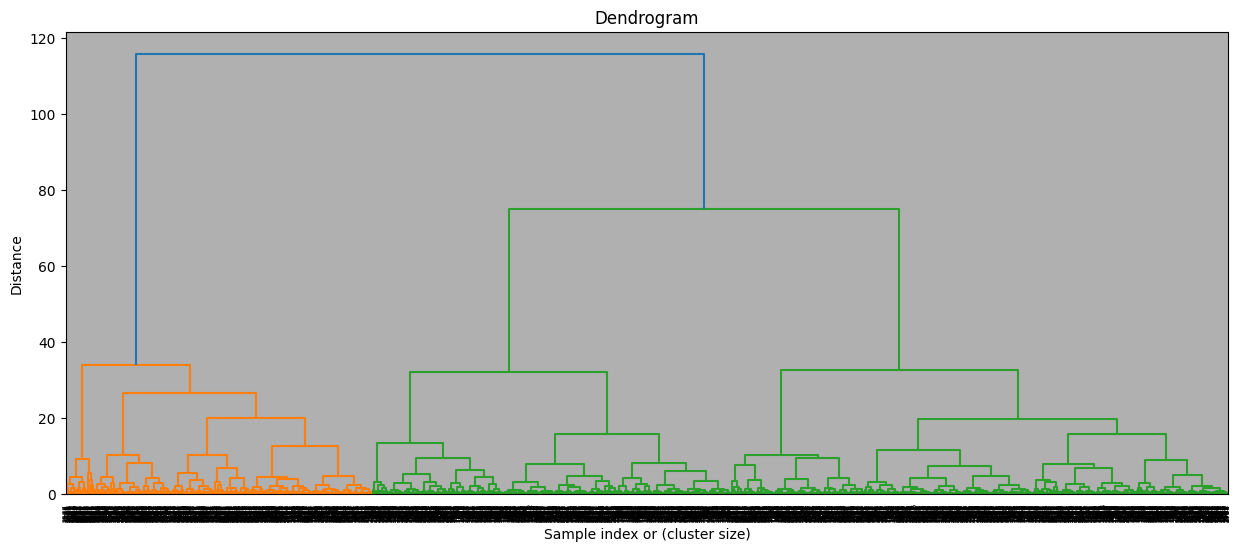

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

linked = linkage(normalized_features, method='ward')

plt.figure(figsize=(15, 6))
dendrogram(linked,
           truncate_mode='level',
           p=30,
           show_leaf_counts=True)
plt.title("Dendrogram")
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance")
plt.grid(True)
plt.show()


In [8]:
# Agglomerative Clustering
n_clusters = 2
hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = hc.fit_predict(normalized_features)

# Evaluation
sil_score = silhouette_score(normalized_features, labels)
dbi_score = davies_bouldin_score(normalized_features, labels)
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi_score:.4f}")


Silhouette Score: 0.4468
Davies-Bouldin Index: 0.7529


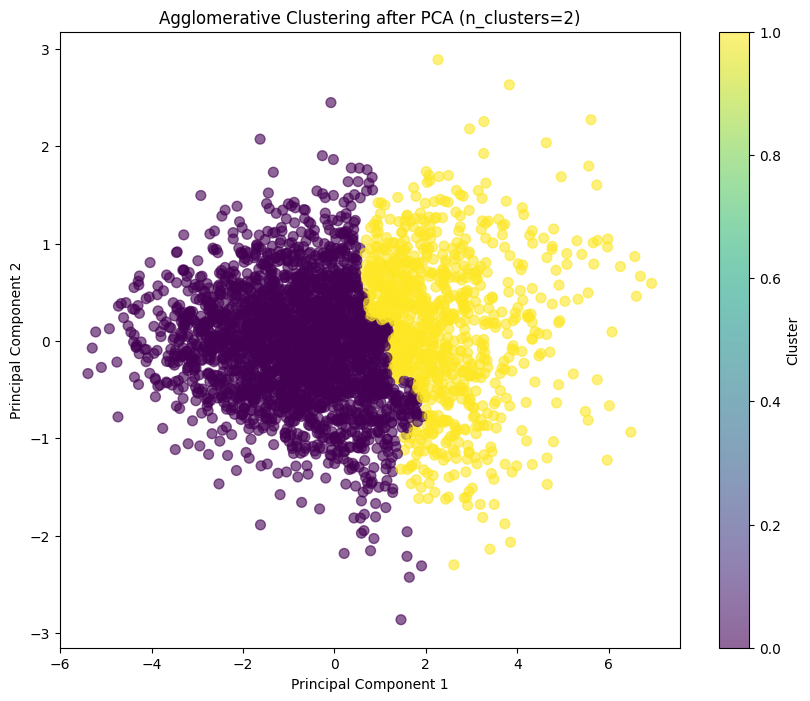

In [9]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_features)

# Create the 2D plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=labels,
    cmap='viridis',
    s=50,
    alpha=0.6
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f"Agglomerative Clustering after PCA (n_clusters={n_clusters})")
plt.colorbar(scatter, label='Cluster')
plt.show()